# **Installing Github Repo**

In [ ]:
pip install git+https://github.com/DiffEqML/torchdyn.git

  Cloning https://github.com/DiffEqML/torchdyn.git to /tmp/pip-req-build-m2cdvrqb
  Running command git clone -q https://github.com/DiffEqML/torchdyn.git /tmp/pip-req-build-m2cdvrqb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 563kB 18.4MB/s 
     / 4.8MB 18.5MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.6MB 38.0MB/s 
     |████████████████████████████████| 829kB 51.3MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 276kB 55.1MB/s 
     |████████████████████████████████| 174kB 49.4MB/s 
  Created wheel for torchdyn: filename=torchdyn-0.2.2.2.dev25+g3251529-cp36-none-any.whl size=44133 sha256=ce34b14b6a3b34f338498d978e37fe2cf8d13ce1933d2c7af99dfd360940958e
  Stored in directory: /tmp/pip-ephem

In [ ]:
pip install git+https://github.com/google-research/torchsde.git

  Cloning https://github.com/google-research/torchsde.git to /tmp/pip-req-build-up5a2dy8
  Running command git clone -q https://github.com/google-research/torchsde.git /tmp/pip-req-build-up5a2dy8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.5MB 252kB/s 
     |████████████████████████████████| 25.9MB 1.7MB/s 
  Created wheel for torchsde: filename=torchsde-0.2.1-cp36-none-any.whl size=54172 sha256=3634b54b487765039e7f9b0eb3c0cfce8057b46a8381eb3e4f9a25e2175d82ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt_api0p/wheels/31/b5/4b/53c7d7c124c1bbfebd2c5f429ca86b5e59f6cd4718dc0f1229
Successfully built torchsde
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.4 which is incompatible.
ERROR: datascience 0.10.6 has require

# **Loading Libraries**

In [ ]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import imageio

import sys ; sys.path.append('../')
from torchdyn.models import *; from torchdyn.datasets import *
from torchdyn import *
import torchdiffeq
import os
import time
from google.colab import files

from IPython.display import clear_output
from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
import pytorch_lightning as pl
import torch.utils.data as Data
from torch.nn  import functional as F 
from torch.autograd import Variable
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

use_cuda = torch.cuda.is_available()
import warnings
warnings.filterwarnings('ignore')
use_cuda
#device

True

# **Data Loading**

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/adityajaas/CS771A_term_project/master/RELIANCE.csv')
data.set_index(pd.Index(np.linspace(1, len(data.index), len(data.index), dtype = int)))
data['Date']= pd.to_datetime(data['Date']) 
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,RELIANCE,EQ,891.15,886.3,892.00,883.65,888.00,887.90,887.62,677439,6.013059e+13,16263,286377,0.4227
1,2015-01-02,RELIANCE,EQ,887.90,888.1,896.05,884.30,884.95,885.55,889.39,1675827,1.490461e+14,31269,1048543,0.6257
2,2015-01-05,RELIANCE,EQ,885.55,885.0,890.90,874.10,875.55,875.85,881.88,2309591,2.036781e+14,67035,1393132,0.6032
3,2015-01-06,RELIANCE,EQ,875.85,870.0,873.00,832.00,832.50,836.10,847.60,4258043,3.609133e+14,120767,2353273,0.5527
4,2015-01-07,RELIANCE,EQ,836.10,837.1,858.80,837.00,858.00,854.30,849.81,4736315,4.024972e+14,125939,2885468,0.6092


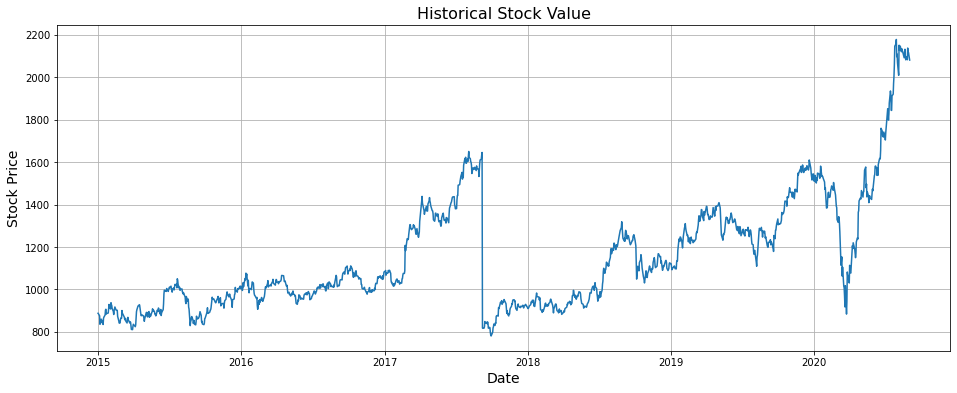

In [ ]:
# Visualize the plot
plt.figure(figsize=(16,6))
plt.plot(data['Date'],data['Close'])
plt.title('Historical Stock Value', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Stock Price', fontsize = 14)
plt.grid()
plt.show()

# **Data Cleaning and Splitting**

In [ ]:
# Create new dataframe with only relevant columns
stk_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
stk_data['Date'] = data['Date']
stk_data['Open'] = data['Open']
stk_data['High'] = data['High']
stk_data['Low'] = data['Low']
stk_data['Close'] = data['Close']
stk_data.head()

,Date,Open,High,Low,Close
0,2015-01-01,886.3,892.00,883.65,887.90
1,2015-01-02,888.1,896.05,884.30,885.55
2,2015-01-05,885.0,890.90,874.10,875.85
3,2015-01-06,870.0,873.00,832.00,836.10
4,2015-01-07,837.1,858.80,837.00,854.30


In [ ]:
# Define the training set
percent_training: float = 0.80
num_training_samples = int(np.ceil(percent_training*len(stk_data))) # number of training samples in int
training_set = stk_data.iloc[:num_training_samples, 4:5].values # Extract the Close values for training data

#Define the test data
num_testing_samples: int = len(stk_data) - num_training_samples # number of test samples in int 
testing_set = stk_data.iloc[-num_testing_samples:, 4:5].values # Extract the Close values for test data
print('Training set shape:', training_set.shape, '\n', 'Testing set shape:', testing_set.shape)

Training set shape: (1121, 1) 
 Testing set shape: (280, 1)


**Generting y_train, y_test, t_s**

In [ ]:
scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set) #2D (num_training_samples, 1)
testing_set_scaled = scaler.transform(testing_set) # 2D ndarray (num_testing_samples, 1)

In [ ]:
sequence_length: int = 32 # Number of x_i for each y_i

x_train = np.array([training_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(training_set_scaled))]) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1])) # 3D training set (num_training_samples, sequence_length, 1) 

x_test = np.array([testing_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(testing_set_scaled))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1])) #3D test set (num_testing_samples, sequence_length, 1)

y_train = np.array([training_set_scaled[i, 0] for i in range(sequence_length, len(training_set_scaled))]) # 2D (num_training_samples, 1)
y_test = np.array([testing_set_scaled[i, 0] for i in range(sequence_length, len(testing_set_scaled))]) # 2D (num_testing_samples, 1)
y_test = np.reshape(y_test, (y_test.shape[0])) # 1D (num_testing_samples, )

print('x_train shape:', x_train.shape, '\n', 'x_test shape:', x_test.shape, '\n', 'y_train shape:', y_train.shape, '\n', 'y_test shape:', y_test.shape)

ts_  = np.arange(0, y_train.shape[0])
ts_ext_ = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
ts_full_ = np.arange(0, y_train.shape[0] + y_test.shape[0])

# Since each year has 252 trading days on average
ts_ = ts_/252; ts_ext_ = ts_ext_/252; ts_full_ = ts_full_/252 # ts_[-1] = 4.44444, ts_ext_[-1] : 5.5555

print('ts_ shape:', ts_.shape, '\n', 'ts_ext_ shape:', ts_ext_.shape, '\n', 'ts_full_ shape:', ts_full_.shape)

x_train shape: (1089, 32) 
 x_test shape: (248, 32) 
 y_train shape: (1089,) 
 y_test shape: (248,)
ts_ shape: (1089,) 
 ts_ext_ shape: (248,) 
 ts_full_ shape: (1337,)


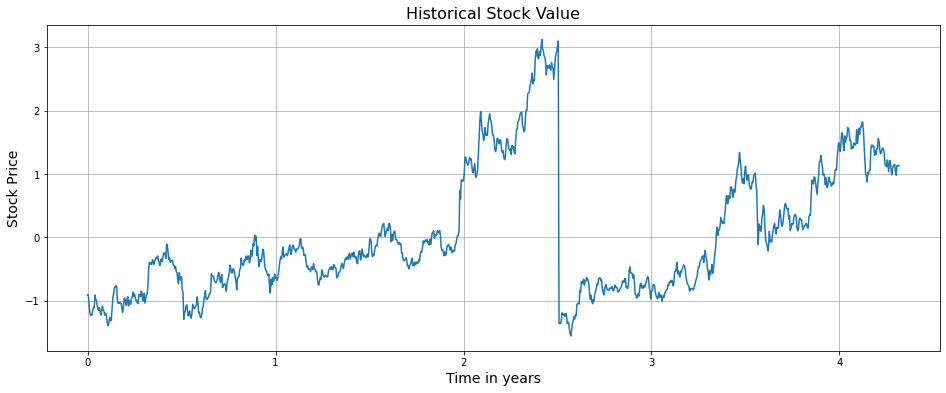

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts_,y_train)
plt.title('Historical Stock Value', fontsize = 16)
plt.xlabel('Time in years', fontsize = 14)
plt.ylabel('Stock Price', fontsize = 14)
plt.grid()
plt.show()

In [ ]:
device = torch.device('cuda' if use_cuda else 'cpu')
# device = 'cpu'
xs = torch.tensor(x_train).float().to(device)
ys = torch.tensor(y_train).float().to(device)
ys = ys.view(y_train.shape[0],1)
ts = torch.tensor(ts_).float().to(device)
ts = ts.view(ts_.shape[0],1)

xs_ext = torch.tensor(x_test).float().to(device)
ys_ext = torch.tensor(y_test).float().to(device)
ys_ext = ys_ext.view(y_test.shape[0],1)
ts_ext = torch.tensor(ts_ext_).float().to(device)
ts_ext = ts_ext.view(ts_ext_.shape[0],1)
ts_full = torch.tensor(ts_full_).float().to(device)
ts_full = ts_full.view(ts_full_.shape[0],1)

print('xs shape:', xs.shape, '\n', 'xs_ext shape:', xs_ext.shape, '\n', 'ys shape:', ys.shape, '\n', 'ys_ext shape:', ys_ext.shape)
print('ts shape:', ts.shape, '\n', 'ts_ext shape:', ts_ext.shape, '\n', 'ts_full shape:', ts_full.shape)

xs shape: torch.Size([1089, 32]) 
 xs_ext shape: torch.Size([248, 32]) 
 ys shape: torch.Size([1089, 1]) 
 ys_ext shape: torch.Size([248, 1])
ts shape: torch.Size([1089, 1]) 
 ts_ext shape: torch.Size([248, 1]) 
 ts_full shape: torch.Size([1337, 1])


# **Define ODE_solver and Model. Train Data**

In [ ]:
train = Data.TensorDataset(xs, ys)
trainloader = Data.DataLoader(train, batch_size=x_train.shape[0], shuffle=False)

In [ ]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model.to(device)
        self.epoch = 1

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        epoch = self.epoch
        x, y = batch
        y_hat = self.model(x)
        loss = nn.functional.mse_loss(y_hat, y, True)
        logs = {'train_loss': loss}
        
        # Save plots while training
        
        plt.figure(figsize = (8, 4))
        plt.plot(ts_, scaler.inverse_transform(y_hat.cpu().detach().numpy()))
        plt.plot(ts_, scaler.inverse_transform(y.cpu().detach().numpy()))
        plt.ylim(750,1700)
        img_path = os.path.join('/content/output/', f'train_{epoch}.png')
        plt.savefig(img_path, dpi = 300)
        plt.close()
        
        predict = self.model(xs_ext)
        predict_loss = nn.functional.mse_loss(predict, ys_ext, True)
        plt.figure(figsize = (8, 4))
        plt.plot(ts_ext_, scaler.inverse_transform(predict.cpu().detach().numpy()))
        plt.plot(ts_ext_, scaler.inverse_transform(ys_ext.cpu().detach().numpy()))
        plt.ylim(800,2300)
        img_path = os.path.join('/content/output/', f'test_{epoch}.png')
        plt.savefig(img_path, dpi = 300)
        plt.close()
        self.epoch = self.epoch + 1

        self.logger.experiment.add_scalar("Loss - Train",
                                            loss,
                                            self.epoch)
        self.logger.experiment.add_scalar("Loss - Test",
                                            predict_loss,
                                            self.epoch)
        batch_dictionary={
            "loss": loss,
            "log": logs,
        }


        return batch_dictionary

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay = 0.1)

    def train_dataloader(self):
        return trainloader

In [ ]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(sequence_length , 64).to(device),
        nn.ELU().to(device),
        # nn.Dropout(p=0.2).to(device),
        nn.Linear(64 , 128).to(device),
        nn.ELU().to(device),
        # nn.Dropout(p=0.2).to(device),
        nn.Linear(128 , 64).to(device),
        nn.ELU().to(device),
        # nn.Dropout(p=0.2).to(device),
        nn.Linear(64, sequence_length).to(device))

#lstm_layer = nn.LSTM(32, 128, 3)
#inp = torch.randn(x_train.shape[0], 32, xs.shape())
#hidden_state = torch.randn(3, x_train.shape[0], 128)
#cell_state = torch.randn(3, x_train.shape[0], 128)
#hidden = (hidden_state, cell_state) 
#out, hidden = lstm_layer(inp, hidden)
# Neural ODE
neuralde = NeuralDE(f, sensitivity='adjoint', solver='dopri8', atol = 1.4e-5).to(device)
model = nn.Sequential(neuralde,
                      nn.Linear(sequence_length, 1).to(device))

# **Train Model**

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger as TBlogger

path = os.path.join('/content/', 'output')
os.makedirs(path, exist_ok=True)
learn = Learner(model)
trainer = pl.Trainer(min_epochs= 599, 
                     max_epochs= 600, 
                     progress_bar_refresh_rate=20, 
                     gpus= 0, 
                     logger= TBlogger(save_dir=os.getcwd(), name='logs')
                     )
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 20.8 K


1

## **TensorBoard Visualization**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [ ]:
!tensorboard dev upload --logdir logs \
    --name "(optional) My latest experiment" \

In [ ]:
TestLoss = pd.read_csv('Loss-Test.csv')
TrainLoss = pd.read_csv('Loss-Train.csv')

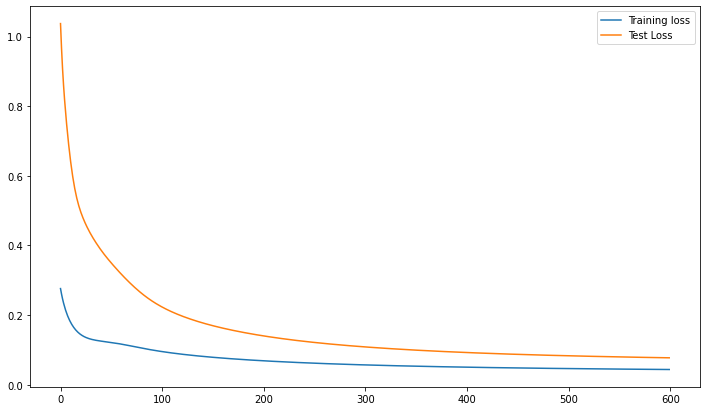

0.07705966383218765


In [ ]:
test_losses = TestLoss.iloc[:,-1]
train_losses = TrainLoss.iloc[:,-1]

plt.figure(figsize=(12,7))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(('Training loss','Test Loss'))
plt.savefig(os.path.join('/content/output/','Loss'), dpi=300)
plt.show()
print(test_losses[599])

# **Test and plot data**

In [ ]:
out = model(xs).cpu().detach()
print(out.shape)
predict = model(xs_ext).cpu().detach()
print(predict.shape)

torch.Size([1089, 1])
torch.Size([248, 1])


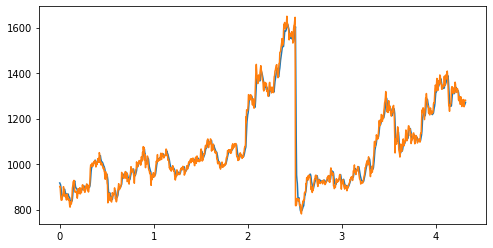

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(ts_, scaler.inverse_transform(out.numpy()))
plt.plot(ts_, scaler.inverse_transform(ys.cpu().detach().numpy()))
plt.show()

In [ ]:
%cp -av output output1

In [ ]:
for i in range(1, 599, 2):
  os.remove(os.path.join('/content/output1/', f'test_{i}.png'))
  os.remove(os.path.join('/content/output1/', f'train_{i}.png'))

0.07701241


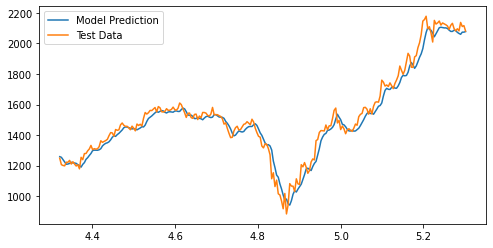

In [ ]:
# print(nn.functional.mse_loss(predict.cpu(), ys_ext.cpu()))
from sklearn.metrics import mean_squared_error as mse

print(mse(predict.numpy(),ys_ext.cpu().detach().numpy()))

plt.figure(figsize = (8, 4))
plt.plot(ts_ext_, scaler.inverse_transform(predict.numpy()))
plt.plot(ts_ext_, scaler.inverse_transform(ys_ext.cpu().detach().numpy()))
plt.legend(('Model Prediction', 'Test Data'))
plt.show()

# **Download Data**

In [ ]:
!zip -r /content/ODE_Iteration1_MSE_.zip /content/output

# files.download("/content/SDE_Iteration5_MSE_.zip")

  adding: content/output1/ (stored 0%)
  adding: content/output1/train_256.png (deflated 8%)
  adding: content/output1/train_594.png (deflated 8%)
  adding: content/output1/test_592.png (deflated 9%)
  adding: content/output1/train_506.png (deflated 8%)
  adding: content/output1/train_532.png (deflated 8%)
  adding: content/output1/train_206.png (deflated 7%)
  adding: content/output1/train_134.png (deflated 7%)
  adding: content/output1/test_348.png (deflated 9%)
  adding: content/output1/test_2.png (deflated 9%)
  adding: content/output1/train_232.png (deflated 7%)
  adding: content/output1/train_208.png (deflated 7%)
  adding: content/output1/train_336.png (deflated 7%)
  adding: content/output1/test_54.png (deflated 9%)
  adding: content/output1/train_18.png (deflated 7%)
  adding: content/output1/test_32.png (deflated 9%)
  adding: content/output1/test_552.png (deflated 9%)
  adding: content/output1/test_222.png (deflated 9%)
  adding: content/output1/test_548.png (deflated 9%)
  

# **Delete Previous DATA**

In [ ]:
!rm -rf "/content/output/"
!rm -rf "/content/logs"